<a href="https://colab.research.google.com/github/dfavenfre/MNIST-Tensorflow/blob/main/src/notebook/MNIST-Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install tensorboard --quiet
%reload_ext tensorboard

In [ ]:
# Tensorflow Modules
import tensorflow as tf

# Scikit-Learn Modules
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
    )

# Fundamental Modules
import datetime
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import seaborn as sns
import random

In [ ]:
# Clear out previous training logs
!rm -rf ./mc_model_checkpoint/

# Helper Functions

In [ ]:
def divide_to_sets(
    X: np.array,
    y: np.array,
    val_cut: float,
    test_cut: float) -> tuple :

    """
    Divide the dataset into training, testing, and validation sets.

    Parameters:
    X (numpy.array): Feature values of the dataset.
    y (numpy.array): Target values of the dataset.
    val_cut (float): Proportion of data to be used for validation.
    test_cut (float): Proportion of data to be used for testing.

    Returns:
    tuple: A tuple containing X_train, X_test, y_train, y_test, X_val, y_val.
    """

    validation_size = int(len(X) * val_cut)
    X_val = X[-validation_size:]
    y_val = y[-validation_size:]
    X_train, X_test, y_train, y_test = train_test_split(
        X[:-validation_size],
        y[:-validation_size],
        test_size=test_cut,
        shuffle=True,
        random_state=42
    )

    return X_train, X_test, y_train, y_test, X_val, y_val

def plot_random_image(
    model,
    images,
    true_labels,
    classes):

  i = random.randint(0, len(images))

  target_image = images[i]
  pred_probs = model.predict(target_image.reshape(1,28,28))
  pred_label = classes[pred_probs.argmax()]
  true_label = classes[true_labels[i]]

  plt.imshow(target_image, cmap=plt.cm.binary)

  if pred_label==true_label:
    color="green"
    plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(
      pred_label,
      100*tf.reduce_max(pred_probs),
      true_label
    ),color=color
  )
  else:
    color ="red"
    plt.xlabel("Pred: {} {:2.0f}% False Prediction / (True: {})".format(
      pred_label,
      100*tf.reduce_max(pred_probs),
      true_label
    ),color=color
  )


# Exploratory Data Analysis For Binary Classification Data

In [ ]:
X, y = make_circles(
    n_samples=1000,
    noise=0.03,
    shuffle=True,
    random_state=42)

X_train, X_test, y_train, y_test, X_val, y_val = divide_to_sets(X, y, 0.1, 0.25)

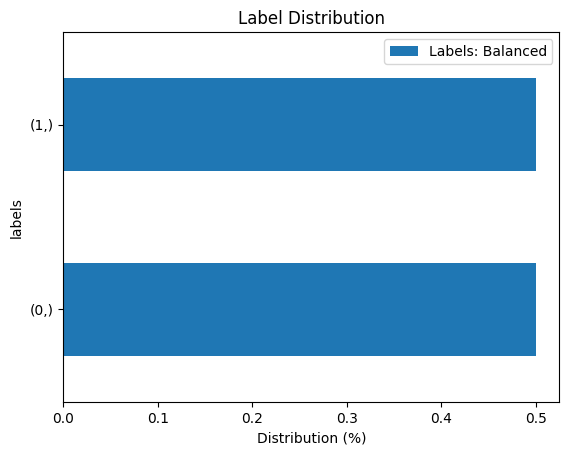

In [ ]:
dummy_labels = y.copy()
dummy_labels_df = pd.DataFrame(dummy_labels)
dummy_labels_df.value_counts(normalize=True).sort_values().plot(kind="barh");
plt.ylabel("labels");
plt.xlabel("Distribution (%)");
plt.title("Label Distribution")
if dummy_labels_df[dummy_labels_df[0] == 0].shape[0] == dummy_labels_df[dummy_labels_df[0] == 1].shape[0]:
    legend_label = 'Labels: Balanced'
else:
    legend_label = 'Labels: Imbalanced'

plt.legend([legend_label]);

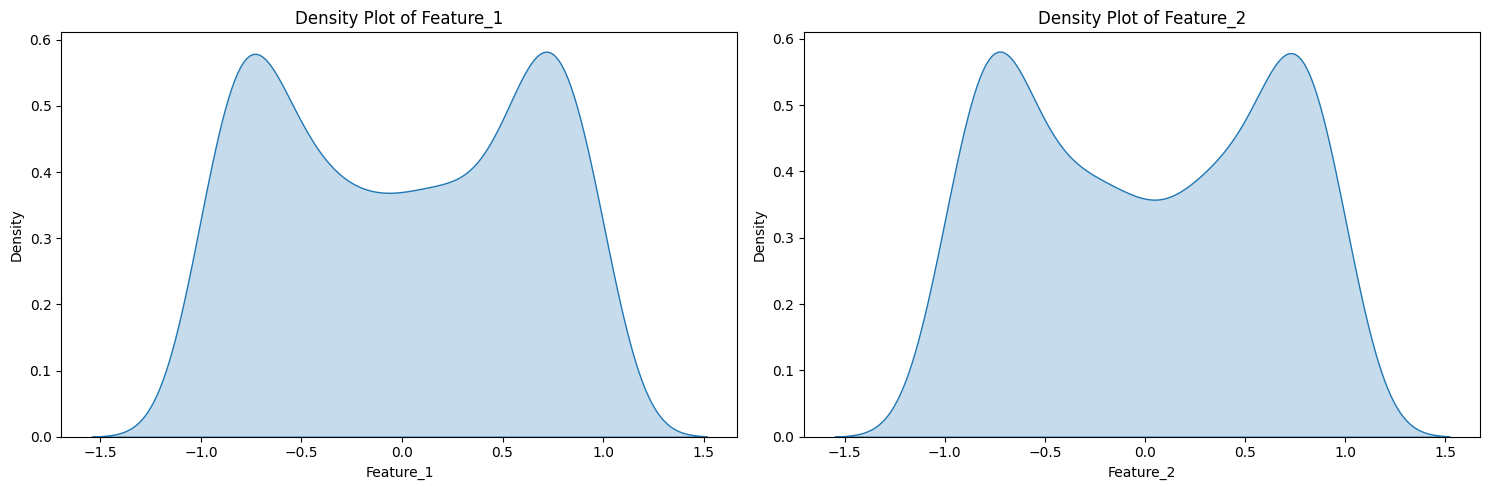

In [ ]:
feature_data_df = pd.DataFrame(X, columns=["Feature_1","Feature_2"])
numeric_columns = feature_data_df.select_dtypes("number").columns

# Create a single figure with subplots
num_plots = len(numeric_columns)
fig, axes = plt.subplots(1, num_plots, figsize=(15, 5))

# Plot density plots for numeric columns in subplots
for i, numeric_col in enumerate(numeric_columns):
    sns.kdeplot(data=feature_data_df, x=numeric_col, fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f'Density Plot of {numeric_col}')
    axes[i].set_xlabel(numeric_col)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

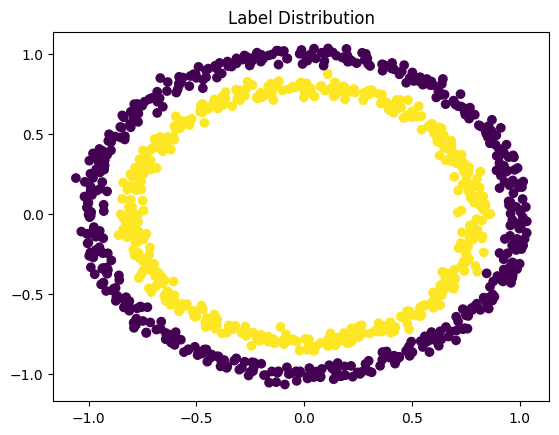

In [ ]:
plt.scatter(feature_data_df["Feature_1"], feature_data_df["Feature_2"], c=y);plt.title("Label Distribution");

# Modelling For Binary Classification

## Callbacks

In [ ]:
tf.random.set_seed(42)

# Visualize the training on Tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Save model checkpoint with best epoch
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_checkpoint/model-{epoch:02d}-{accuracy:.3f}.hdf5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=0
)

# Drop the learning rate when model does not improve its performance metric
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    mode="max",
    factor=0.1,
    patience=5,
    verbose=0,
    min_lr=1e-7
)

# Force stop the training if model does not improve for a specific number of epochs
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    patience=10,
    verbose=0,
)


## Baseline Model

In [ ]:
tf.random.set_seed(42)

# Baseline Model
model_baseline=tf.keras.Sequential([
    tf.keras.layers.Dense(
        units=100,
        kernel_initializer=tf.keras.initializers.LecunNormal(),
        kernel_regularizer=tf.keras.regularizers.L1(),
        bias_initializer=tf.keras.initializers.LecunNormal(),
        activation="relu",
        name="First-Hidden-Layer"
    ),
    tf.keras.layers.Dense(1, activation="relu", name="Output-Layer")
    ], name="Baseline-model"
)

# Compile the model
model_baseline.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit and evaluate the model
baseline_model_history=model_baseline.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=1,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[
        cb_checkpoint,
        cb_reducelr,
        cb_earlystop,
        tensorboard_callback
        ]
    )

Epoch 1/100
675/675 - 2s - loss: 2.3834 - accuracy: 0.3926 - val_loss: 1.8380 - val_accuracy: 0.4533 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 2/100
675/675 - 1s - loss: 1.7423 - accuracy: 0.4593 - val_loss: 1.6672 - val_accuracy: 0.4400 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 3/100
675/675 - 2s - loss: 1.5676 - accuracy: 0.5704 - val_loss: 1.4607 - val_accuracy: 0.6711 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 4/100
675/675 - 2s - loss: 1.3851 - accuracy: 0.7126 - val_loss: 1.2809 - val_accuracy: 0.7956 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 5/100
675/675 - 1s - loss: 1.2183 - accuracy: 0.7881 - val_loss: 1.2046 - val_accuracy: 0.5600 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 6/100
675/675 - 1s - loss: 1.0736 - accuracy: 0.8652 - val_loss: 1.0486 - val_accuracy: 0.7644 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 7/100
675/675 - 1s - loss: 0.9322 - accuracy: 0.9096 - val_loss: 0.9072 - val_accuracy: 0.9378 - lr: 0.0010 - 1s/epoch - 2ms/step
Epoch 8/100
675/675 - 1s - loss: 0.8171 - accura

In [ ]:
# Display model summary
model_baseline.summary(show_trainable=True, expand_nested=True)

Model: "Baseline-model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 First-Hidden-Layer (Dense)  (1, 100)                  300       Y          
                                                                            
 Output-Layer (Dense)        (1, 1)                    101       Y          
                                                                            
Total params: 401 (1.57 KB)
Trainable params: 401 (1.57 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________________________________________


## Baseline Model evaluation

In [ ]:
# Load best model and compare validation data with training accuracy score
best_baseline_model = tf.keras.models.load_model("/content/model_checkpoint/model-15-0.999.hdf5")

In [ ]:
y_preds = best_baseline_model.predict(X_val)
print("baseline model accuracy: {:.1f}%".format(accuracy_score(y_val, tf.round(tf.squeeze(y_preds)))*100))

4/4 [==============================] - 0s 3ms/step
baseline model accuracy: 100.0%


79/79 [==============================] - 0s 4ms/step


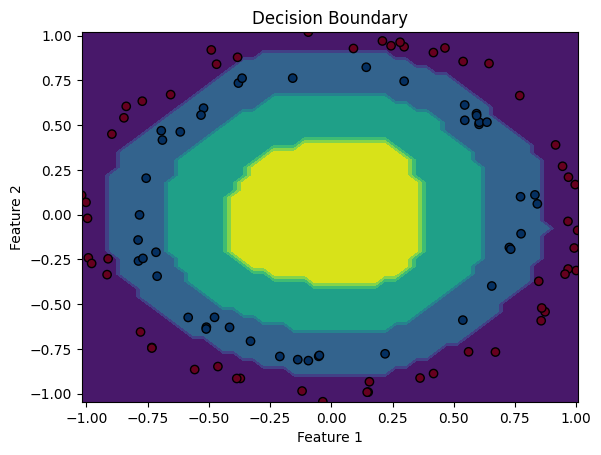

In [ ]:
feature_1, feature_2 = np.meshgrid(
    np.linspace(X_val[:, 0].min(), X_val[:, 0].max(), 50),
    np.linspace(X_val[:, 1].min(), X_val[:, 1].max(), 50)
)

mesh_grid_predictions = best_baseline_model.predict(np.c_[feature_1.ravel(), feature_2.ravel()])
mesh_grid_predictions = tf.round(tf.squeeze(mesh_grid_predictions))
mesh_grid_predictions = tf.reshape(mesh_grid_predictions, feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=mesh_grid_predictions)

display.plot()
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.RdBu, edgecolor="black");plt.xlabel('Feature 1');plt.ylabel('Feature 2');plt.title('Decision Boundary');

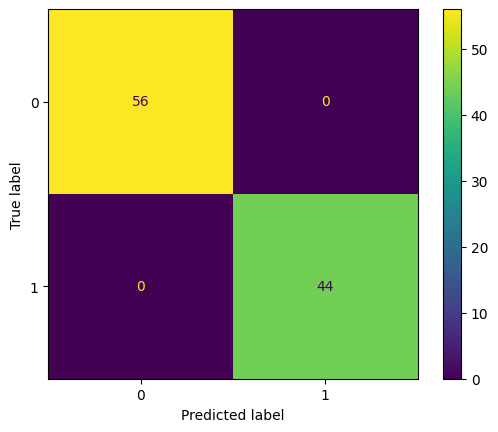

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, tf.round(tf.squeeze(y_preds)));

In [ ]:
print(classification_report(y_val, tf.round(tf.squeeze(y_preds)), target_names=["Class 0","Class 1"]))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        56
     Class 1       1.00      1.00      1.00        44

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



# Exploratory Data Analysis For Fashion Mnist Data

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
y_train[:15]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7], dtype=uint8)

We will be in need of `SparseCategoricalCrossEntropy()` loss function since the labels are integer.   

Alternatively, we could simply use `tf.one_hot()` on both training and test labels as well. In that case, `CategoricalCrossEntropy()` would be the loss function applied to the neural network.

```
model.fit(X_train, tf.one_hot(y_train, depth=10),
          validation_data=(X_test, tf.one_hot(y_test, depth=10)))

"""depth parameter should be equal to the number of labels available"""
```


- https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

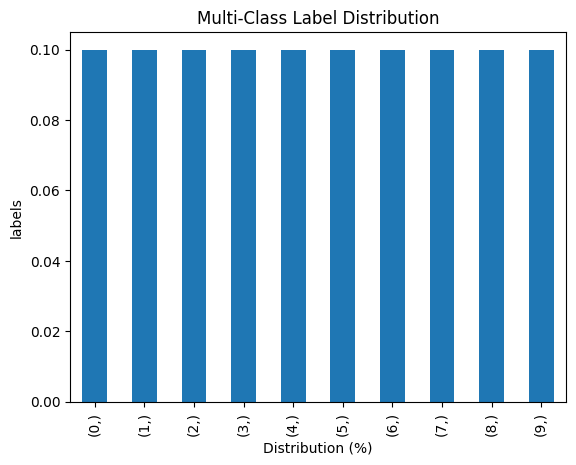

In [ ]:
dummy_labels = y_train.copy()
dummy_labels_df = pd.DataFrame(dummy_labels)
dummy_labels_df.value_counts(normalize=True).sort_values().plot(kind="bar");
plt.ylabel("labels")
plt.xlabel("Distribution (%)")
plt.title("Multi-Class Label Distribution")
plt.show()

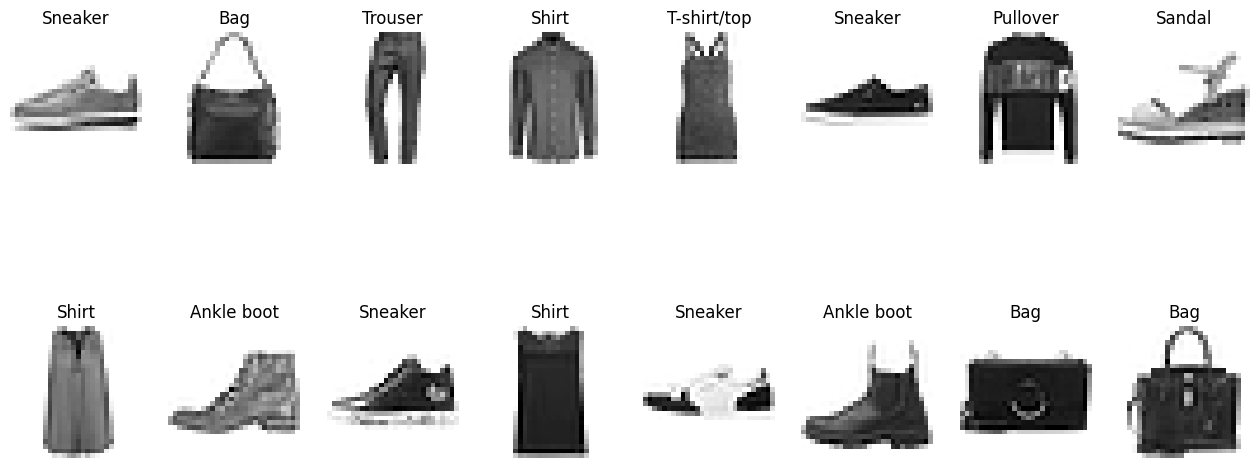

In [ ]:
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
plt.figure(figsize=(16,7))
for i in range(16):
  ax = plt.subplot(2, 8, i+1)
  rand_index = random.choice(range(len(X_train)))
  plt.imshow(X_train[rand_index], cmap=plt.cm.binary)
  plt.title(class_labels[y_train[rand_index]])
  plt.axis(False)

# Modelling for Multi-Class Classification (fashion-mnist)

## Callbacks

In [ ]:
tf.random.set_seed(42)

# Visualize the training on Tensorboard
log_dir = "mc_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Save model checkpoint with best epoch
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="mc_model_checkpoint/model-{epoch:02d}-{accuracy:.3f}.hdf5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=0
)

# Drop the learning rate when model does not improve its performance metric
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    mode="max",
    factor=0.1,
    patience=10,
    verbose=0,
    min_lr=1e-7
)

# Force stop the training if model does not improve for a specific number of epochs
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    patience=20,
    verbose=0,
)


## Baseline for multi-class model



In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# Data normalization
norm_X_train, norm_X_test = X_train / 255.0, X_test / 255.0

In [ ]:
tf.random.set_seed(42)

# Multiclass Model
model_multiclass = tf.keras.Sequential(
    [
    tf.keras.layers.Flatten(input_shape=(28,28), name="Layer-Flatten-1"),
    tf.keras.layers.Dense(
        units=100,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.LecunNormal(),
        kernel_regularizer=tf.keras.regularizers.L2(),
        bias_initializer=tf.keras.initializers.LecunNormal(),
        bias_regularizer=tf.keras.regularizers.L2(),
        name="Layer-FC_1"
        ),
    tf.keras.layers.Dropout(0.2, name="Layer-Dropout-1"),
    tf.keras.layers.Dense(
        units=100,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.LecunNormal(),
        kernel_regularizer=tf.keras.regularizers.L2(),
        bias_initializer=tf.keras.initializers.LecunNormal(),
        bias_regularizer=tf.keras.regularizers.L2(),
        name="Layer-FC_2"
        ),
    tf.keras.layers.Dropout(0.2, name="Layer-Dropout-2"),
    tf.keras.layers.Dense(
        units=10,
        activation=tf.keras.activations.softmax,
        kernel_initializer=tf.keras.initializers.LecunNormal(),
        kernel_regularizer=tf.keras.regularizers.L2(),
        bias_initializer=tf.keras.initializers.LecunNormal(),
        bias_regularizer=tf.keras.regularizers.L2(),
        name="Layer-Output"
        )
      ], name="Multiclass-Classification-Image-Detection"
)

# Compile the model
model_multiclass.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]

)

# Fit and evaluate the model
model_multiclass.fit(
    norm_X_train, tf.one_hot(y_train, depth=10),
    epochs=100,
    validation_data=(norm_X_test, tf.one_hot(y_test, depth=10)),
    callbacks=[
        cb_checkpoint,
        cb_reducelr,
        cb_earlystop,
        tensorboard_callback
        ])

In [ ]:
model_multiclass.summary()

Model: "Multiclass-Classification-Image-Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 Layer-FC_1 (Dense)          (None, 100)               78500     
                                                                 
 Layer-Dropout-1 (Dropout)   (None, 100)               0         
                                                                 
 Layer-FC_2 (Dense)          (None, 100)               10100     
                                                                 
 Layer-Dropout-2 (Dropout)   (None, 100)               0         
                                                                 
 Layer-Output (Dense)        (None, 10)                1010      
                                                                 
Total params: 89610 (350.

## Model Evaluation

In [ ]:
# Load best model and compare validation data with training accuracy score
best_multiclass_model = tf.keras.models.load_model("/content/mc_model_checkpoint/model-46-0.813.hdf5")

In [ ]:
multiclass_preds = (best_multiclass_model.predict(norm_X_test)).argmax(axis=1)

313/313 [==============================] - 1s 3ms/step


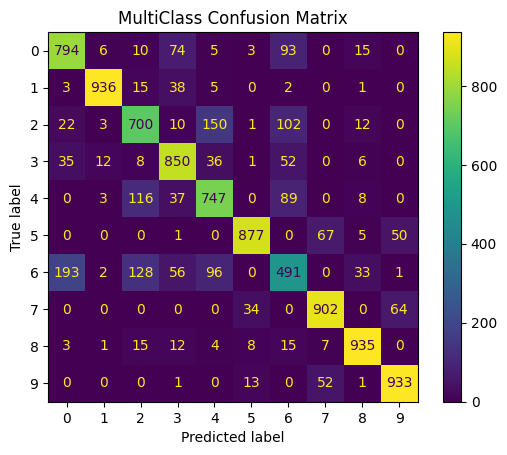

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, multiclass_preds);plt.title("MultiClass Confusion Matrix");

In [ ]:
print(classification_report(y_test, multiclass_preds, target_names=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]))

              precision    recall  f1-score   support

 T-shirt/top       0.76      0.79      0.77      1000
     Trouser       0.97      0.94      0.95      1000
    Pullover       0.71      0.70      0.70      1000
       Dress       0.79      0.85      0.82      1000
        Coat       0.72      0.75      0.73      1000
      Sandal       0.94      0.88      0.91      1000
       Shirt       0.58      0.49      0.53      1000
     Sneaker       0.88      0.90      0.89      1000
         Bag       0.92      0.94      0.93      1000
  Ankle boot       0.89      0.93      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.81      0.82      0.81     10000
weighted avg       0.81      0.82      0.81     10000



1/1 [==============================] - 0s 20ms/step


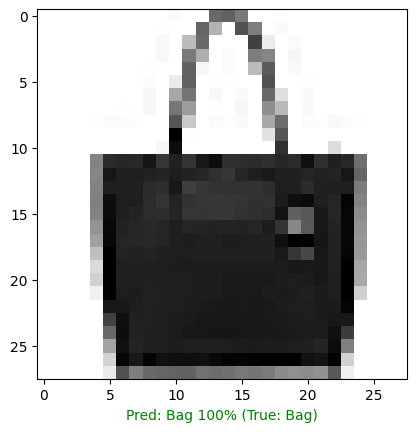

In [ ]:
plot_random_image(model=best_multiclass_model,
                  images=X_test,
                  true_labels=y_test,
                  classes=class_labels)

# Display model training on Tensorboard

In [ ]:
# Access to tensorboard
!tensorboard dev upload --logdir ./mc_logs/ \
  --name "MultiClass Image Classification Model Training "